In [1]:
import torch
import tqdm
import logger
import numpy as np
import torch.nn as nn
import pickle
import metrics
from skimage import io
from skimage import transform
# from model import FusionNet, DilationCNN, UNet
# from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader
from loss import dice_loss
import imageio


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
import torchvision.models as tormodel
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import glob
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

def mkdir_if_missing(save_dir):
    if os.path.exists(save_dir):
        return 1
    else:
        os.makedirs(save_dir)
        return 0

# Dataloader

In [2]:
import torch.utils.data as data
from PIL import Image
import os

class GetLoader(data.Dataset):
    def __init__(self, data_root, img_folder, lab_folder, transform=None):
        self.img_root = os.path.join(data_root,img_folder)
        self.mask_root = os.path.join(data_root,lab_folder)
        self.transform = transform
        
        data_list = os.listdir(self.img_root)
        self.n_data = len(data_list)

        self.img_paths = []
        self.lab_paths = []

        for data in data_list:
            self.img_paths.append(os.path.join(self.img_root,data))
            self.lab_paths.append(os.path.join(self.mask_root,data))

    def __getitem__(self, item):
        img_pth, lab_pth = self.img_paths[item], self.lab_paths[item]
        imgs = Image.open(img_pth).convert('RGB')
        labels = np.asarray(imageio.imread(lab_pth))

        if self.transform is not None:
            imgs = self.transform(imgs)
#             labels = self.transform(labels)
        return imgs, labels

    def __len__(self):
        return self.n_data


In [3]:
DATA_DIR = '/home/zhangj41/HW/group_proj/Immune_nuclei'
TRAIN_IMG = 'image_train'
TEST_IMG = 'image_test'
TRAIN_MASK = 'mask_train'
TEST_MASK = 'mask_test'

img_transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
])

'''---train loader---'''
DATASET_TRAIN = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TRAIN_IMG, 
    lab_folder=TRAIN_MASK, 
    transform=img_transform_train
)
DATALOADER_TRAIN = torch.utils.data.DataLoader(
    dataset=DATASET_TRAIN,
    batch_size=50,
    shuffle=True)

'''---test loader---'''
DATASET_TEST = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TEST_IMG, 
    lab_folder=TEST_MASK, 
    transform=img_transform_train
)
DATALOADER_TEST = torch.utils.data.DataLoader(
    dataset=DATASET_TEST,
    batch_size=100,
    shuffle=False)

34


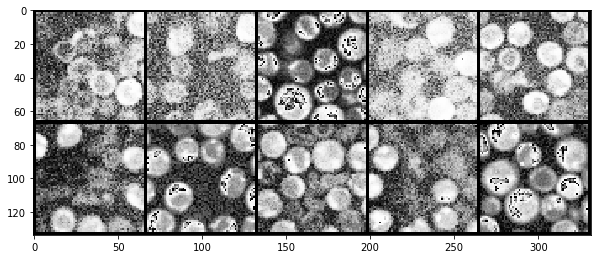

In [4]:
print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
batch_datas, batch_labels = next(iter(DATALOADER_TRAIN)) 
# print(batch_labels)
img = make_grid(batch_datas[0:10], nrow=5, padding=2)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [5]:
# batch_labels_ = batch_labels.unsqueeze(1)
# print(batch_labels_.size())
# img = make_grid(batch_labels_[0:10], nrow=5, padding=2)
# npimg = img.numpy()
# print(npimg.shape)
# plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray', interpolation='nearest')

In [6]:
batch_label = batch_labels[0]
batch_label.size()

torch.Size([64, 64])

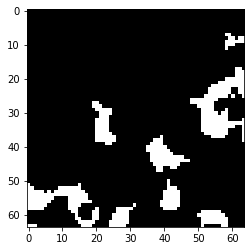

In [7]:
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

# Models

In [8]:
import torch.nn as nn 
import unet_layers as layers


class UNet(nn.Module):
    def __init__(self, num_kernel, kernel_size, dim, target_dim):
        super(UNet, self).__init__()
        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = target_dim

        # encode
        self.encode_1 = layers.DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = layers.DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = layers.DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = layers.DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = layers.UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = layers.UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = layers.UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = layers.UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):
        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)
        pred = self.activate(x)
        return pred

In [9]:
### debug
# batch_datas, batch_labels = next(iter(dataloader_train)) 
# batch_labels.unsqueeze_(1)
# batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()
# unet = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
# unet.cuda()


In [10]:
# loss_function = dice_loss
# pred = unet(batch_datas)
# print(batch_datas.size(), pred.size(), batch_labels.size())
# loss_function(pred, batch_labels)

In [11]:
# print(torch.min(pred),torch.max(pred))
# print(torch.min(batch_labels),torch.max(batch_labels))

# Utils

## Average meter

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Cell segmentation

In [13]:
class CellSeg:
    def __init__(self, unet):
        self.unet = unet
        self.unet.cuda()
        self.optimizer = torch.optim.SGD(self.unet.parameters(),
                                         lr=0.01, momentum=0.9, weight_decay=1e-3)
    
    def scheduler(self, epoch, lr0=1e-3):
        lr = lr0
        if epoch >= 80:
            lr = lr0 * 0.1
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

            
    def train_batch(self,
                    data_loader,
                    epoch):
        '''--- 1. setup network ---'''
        loss_function = dice_loss
#         total_loss = AverageMeter()
#         total_iou = AverageMeter()
#         total_precision = AverageMeter()
        
        # set train state
        self.unet.train()
        len_dataloader = len(data_loader)
        data_iter = iter(data_loader)

        '''--- 2. train network ---'''
        iters=0
        while iters<len_dataloader-1:
            iters+=1
            input_img, class_label = next(data_iter)
            class_label.unsqueeze_(1)
            input_img, class_label = input_img.cuda(), class_label.cuda()
            batch_size = len(class_label)
            '''forward, compute student ce loss'''
            pred_mask = self.unet(input_img)
            loss = loss_function(pred_mask, class_label)
            
            predictions = pred_mask.clone().squeeze().detach().cpu().numpy()
            gt = class_label.clone().squeeze().detach().cpu().numpy()
            ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
            iou_val = np.mean(ious)
            '''backward teacher generate guided-BP map, detach'''
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if iters%1 == 0:
                print('epoch: {}, [iter {} / all {}], loss:{}, iou:{}'\
                      .format(epoch, iters, len_dataloader, 
                              loss.cpu().data.numpy(),
                              iou_val))
        return loss, iou_val
    
    
    def eval_epoch(self, dataloader):
        cudnn.benchmark = True
        loss_function = dice_loss
        '''---evaluation mode---'''
        self.unet.eval()
        len_dataloader = len(dataloader)
        data_test_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_iou = 0
        total_loss = 0
        total_precision = 0
        counter = 0
#         total_iou = []
        with torch.no_grad():
            while i<len_dataloader:
                # test model using target data
                input_img, class_label = next(data_test_iter)
                class_label.unsqueeze_(1)
                input_img, class_label = input_img.cuda(), class_label.cuda()
                batch_size = len(class_label)

                pred_mask = self.unet(input_img)
                dice_loss_ = loss_function(pred_mask, class_label)
                dice_loss_ = dice_loss_.clone().squeeze().cpu().numpy()
                predictions = pred_mask.clone().squeeze().cpu().numpy()
                gt = class_label.clone().squeeze().cpu().numpy()
                ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
                prec = [metrics.compute_precision(p, g, 0.5) for p,g in zip(predictions, gt)]
#                 total_iou.append(np.mean(ious))
                total_loss += np.sum(dice_loss_)
                total_iou += np.sum(ious)
                total_precision += np.sum(prec)
                counter += batch_size
                i += 1
        iou_avg = total_iou/counter #np.mean(total_iou)
        precision_avg = total_precision/counter
        dice_coeff_avg = 1-total_loss/counter
        print('Normal IOU of the dataset: %f' %(iou_avg))
        print('Normal PREC of the dataset: %f' %(precision_avg))
        print('Normal DICE SCORE of the dataset: %f' %(dice_coeff_avg))
        return iou_avg, precision_avg, dice_coeff_avg
        
        
    def Net_train(self,
                  dl_train,dl_val,
                  n_epochs,
                  save_dir):
        loss_ = []
        iou_val_ = []
        acc_ = []
        for epoch in np.arange(n_epochs):
            # training
            self.scheduler(epoch=epoch)
            loss, iou_val = self.train_batch(data_loader=dl_train,
                                                 epoch=epoch)
            loss_.append(loss)
            iou_val_.append(iou_val)
            # save model
            if epoch>=80:
                file_name = 'unet_epoch'+str(epoch)+'.pth'
                torch.save(self.unet.state_dict(), os.path.join(save_dir,file_name))
            # evaluation
            print('================================================================')
            acc = self.eval_epoch(dataloader=dl_val)
            acc_.append(acc)
            print('================================================================')
        return loss_, iou_val_, acc_

# Main

In [14]:
MODEL_SAVE_PATH = '/home/zhangj41/HW/group_proj/Immune_nuclei_models'
mkdir_if_missing(MODEL_SAVE_PATH)
solver = CellSeg(unet=UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1))
loss_, iou_val_, acc_ = solver.Net_train(dl_train=DATALOADER_TRAIN,
                                         dl_val=DATALOADER_TEST,
                                         n_epochs=100,
                                         save_dir=MODEL_SAVE_PATH)

epoch: 0, [iter 1 / all 34], loss:0.6401422023773193, iou:0.10341820120811462
epoch: 0, [iter 2 / all 34], loss:0.6233329176902771, iou:0.11680977791547775
epoch: 0, [iter 3 / all 34], loss:0.6555282473564148, iou:0.10905289649963379
epoch: 0, [iter 4 / all 34], loss:0.638615608215332, iou:0.12129177898168564
epoch: 0, [iter 5 / all 34], loss:0.6280419230461121, iou:0.13512186706066132
epoch: 0, [iter 6 / all 34], loss:0.6367734670639038, iou:0.13801182806491852
epoch: 0, [iter 7 / all 34], loss:0.6268382668495178, iou:0.1545596420764923
epoch: 0, [iter 8 / all 34], loss:0.612563967704773, iou:0.17129041254520416
epoch: 0, [iter 9 / all 34], loss:0.5944377183914185, iou:0.18655537068843842
epoch: 0, [iter 10 / all 34], loss:0.5983008146286011, iou:0.1846236288547516
epoch: 0, [iter 11 / all 34], loss:0.5782811641693115, iou:0.20694923400878906
epoch: 0, [iter 12 / all 34], loss:0.5827263593673706, iou:0.20727573335170746
epoch: 0, [iter 13 / all 34], loss:0.560733437538147, iou:0.22953

epoch: 3, [iter 2 / all 34], loss:0.47688180208206177, iou:0.3210051357746124
epoch: 3, [iter 3 / all 34], loss:0.488116979598999, iou:0.3104266822338104
epoch: 3, [iter 4 / all 34], loss:0.4806026816368103, iou:0.3243532180786133
epoch: 3, [iter 5 / all 34], loss:0.47630709409713745, iou:0.32081151008605957
epoch: 3, [iter 6 / all 34], loss:0.4837561845779419, iou:0.3291727304458618
epoch: 3, [iter 7 / all 34], loss:0.47496169805526733, iou:0.3167136311531067
epoch: 3, [iter 8 / all 34], loss:0.43520230054855347, iou:0.36089879274368286
epoch: 3, [iter 9 / all 34], loss:0.4566364288330078, iou:0.3463629484176636
epoch: 3, [iter 10 / all 34], loss:0.48325419425964355, iou:0.31628674268722534
epoch: 3, [iter 11 / all 34], loss:0.4969642162322998, iou:0.30231621861457825
epoch: 3, [iter 12 / all 34], loss:0.4888356924057007, iou:0.3147256374359131
epoch: 3, [iter 13 / all 34], loss:0.4988245368003845, iou:0.30183812975883484
epoch: 3, [iter 14 / all 34], loss:0.46215808391571045, iou:0.3

epoch: 6, [iter 2 / all 34], loss:0.44862574338912964, iou:0.3534833788871765
epoch: 6, [iter 3 / all 34], loss:0.4381611943244934, iou:0.3557376563549042
epoch: 6, [iter 4 / all 34], loss:0.43310654163360596, iou:0.3682113587856293
epoch: 6, [iter 5 / all 34], loss:0.46993011236190796, iou:0.3277636766433716
epoch: 6, [iter 6 / all 34], loss:0.4308586120605469, iou:0.36943772435188293
epoch: 6, [iter 7 / all 34], loss:0.45030641555786133, iou:0.34657543897628784
epoch: 6, [iter 8 / all 34], loss:0.42915254831314087, iou:0.3767845630645752
epoch: 6, [iter 9 / all 34], loss:0.4471815824508667, iou:0.3575447201728821
epoch: 6, [iter 10 / all 34], loss:0.41623634099960327, iou:0.3743214011192322
epoch: 6, [iter 11 / all 34], loss:0.4333708882331848, iou:0.366450697183609
epoch: 6, [iter 12 / all 34], loss:0.4649926424026489, iou:0.3505915403366089
epoch: 6, [iter 13 / all 34], loss:0.4306104779243469, iou:0.36798739433288574
epoch: 6, [iter 14 / all 34], loss:0.4271487593650818, iou:0.377

epoch: 9, [iter 2 / all 34], loss:0.4066394567489624, iou:0.3931904733181
epoch: 9, [iter 3 / all 34], loss:0.3759525418281555, iou:0.4183720648288727
epoch: 9, [iter 4 / all 34], loss:0.4253193140029907, iou:0.3727477788925171
epoch: 9, [iter 5 / all 34], loss:0.39684635400772095, iou:0.41462430357933044
epoch: 9, [iter 6 / all 34], loss:0.3786199688911438, iou:0.42737433314323425
epoch: 9, [iter 7 / all 34], loss:0.4254884123802185, iou:0.38231492042541504
epoch: 9, [iter 8 / all 34], loss:0.4314146041870117, iou:0.37104716897010803
epoch: 9, [iter 9 / all 34], loss:0.42781710624694824, iou:0.3721531331539154
epoch: 9, [iter 10 / all 34], loss:0.3892759084701538, iou:0.41657745838165283
epoch: 9, [iter 11 / all 34], loss:0.4206060767173767, iou:0.38921257853507996
epoch: 9, [iter 12 / all 34], loss:0.41191399097442627, iou:0.40246260166168213
epoch: 9, [iter 13 / all 34], loss:0.4067830443382263, iou:0.38894030451774597
epoch: 9, [iter 14 / all 34], loss:0.4055366516113281, iou:0.388

epoch: 12, [iter 2 / all 34], loss:0.35927480459213257, iou:0.44308149814605713
epoch: 12, [iter 3 / all 34], loss:0.39051657915115356, iou:0.4091927409172058
epoch: 12, [iter 4 / all 34], loss:0.39702320098876953, iou:0.40251636505126953
epoch: 12, [iter 5 / all 34], loss:0.35053718090057373, iou:0.4557223916053772
epoch: 12, [iter 6 / all 34], loss:0.37439465522766113, iou:0.42474105954170227
epoch: 12, [iter 7 / all 34], loss:0.35738062858581543, iou:0.441685289144516
epoch: 12, [iter 8 / all 34], loss:0.3750680685043335, iou:0.4205307364463806
epoch: 12, [iter 9 / all 34], loss:0.3812103271484375, iou:0.4188033640384674
epoch: 12, [iter 10 / all 34], loss:0.4244304895401001, iou:0.3715081810951233
epoch: 12, [iter 11 / all 34], loss:0.3662475347518921, iou:0.4310140907764435
epoch: 12, [iter 12 / all 34], loss:0.3919258713722229, iou:0.4094841778278351
epoch: 12, [iter 13 / all 34], loss:0.40039217472076416, iou:0.4069231450557709
epoch: 12, [iter 14 / all 34], loss:0.3802314400672

Normal accuracy of the dataset: 0.569836
epoch: 15, [iter 1 / all 34], loss:0.3701971173286438, iou:0.4202255606651306
epoch: 15, [iter 2 / all 34], loss:0.3452916741371155, iou:0.4472687244415283
epoch: 15, [iter 3 / all 34], loss:0.3816937804222107, iou:0.41263094544410706
epoch: 15, [iter 4 / all 34], loss:0.3615533709526062, iou:0.42576563358306885
epoch: 15, [iter 5 / all 34], loss:0.3348182439804077, iou:0.45182177424430847
epoch: 15, [iter 6 / all 34], loss:0.3612504005432129, iou:0.4394058883190155
epoch: 15, [iter 7 / all 34], loss:0.3423272371292114, iou:0.44758206605911255
epoch: 15, [iter 8 / all 34], loss:0.34040623903274536, iou:0.46230795979499817
epoch: 15, [iter 9 / all 34], loss:0.3894653916358948, iou:0.40234023332595825
epoch: 15, [iter 10 / all 34], loss:0.33371955156326294, iou:0.46043074131011963
epoch: 15, [iter 11 / all 34], loss:0.3308020234107971, iou:0.46165329217910767
epoch: 15, [iter 12 / all 34], loss:0.338578462600708, iou:0.4580516815185547
epoch: 15, 

epoch: 17, [iter 33 / all 34], loss:0.323358952999115, iou:0.45848801732063293
Normal accuracy of the dataset: 0.584657
epoch: 18, [iter 1 / all 34], loss:0.33985090255737305, iou:0.43748509883880615
epoch: 18, [iter 2 / all 34], loss:0.32521331310272217, iou:0.4624147117137909
epoch: 18, [iter 3 / all 34], loss:0.3407946228981018, iou:0.4511469900608063
epoch: 18, [iter 4 / all 34], loss:0.3056512475013733, iou:0.48307523131370544
epoch: 18, [iter 5 / all 34], loss:0.3272317051887512, iou:0.46372222900390625
epoch: 18, [iter 6 / all 34], loss:0.32301080226898193, iou:0.47124728560447693
epoch: 18, [iter 7 / all 34], loss:0.34720873832702637, iou:0.4334607422351837
epoch: 18, [iter 8 / all 34], loss:0.3411213159561157, iou:0.43024781346321106
epoch: 18, [iter 9 / all 34], loss:0.331635057926178, iou:0.4510962665081024
epoch: 18, [iter 10 / all 34], loss:0.3211807608604431, iou:0.466790109872818
epoch: 18, [iter 11 / all 34], loss:0.3304789662361145, iou:0.44260260462760925
epoch: 18, [

epoch: 20, [iter 33 / all 34], loss:0.3155214190483093, iou:0.4732058644294739
Normal accuracy of the dataset: 0.595639
epoch: 21, [iter 1 / all 34], loss:0.31219834089279175, iou:0.4733491837978363
epoch: 21, [iter 2 / all 34], loss:0.3118365406990051, iou:0.46825119853019714
epoch: 21, [iter 3 / all 34], loss:0.2989571690559387, iou:0.48713305592536926
epoch: 21, [iter 4 / all 34], loss:0.2837490439414978, iou:0.502773106098175
epoch: 21, [iter 5 / all 34], loss:0.2859574556350708, iou:0.504702091217041
epoch: 21, [iter 6 / all 34], loss:0.2732231616973877, iou:0.5152624845504761
epoch: 21, [iter 7 / all 34], loss:0.3058170676231384, iou:0.4813348650932312
epoch: 21, [iter 8 / all 34], loss:0.300963819026947, iou:0.4735689163208008
epoch: 21, [iter 9 / all 34], loss:0.267897367477417, iou:0.5255517363548279
epoch: 21, [iter 10 / all 34], loss:0.31964248418807983, iou:0.468308687210083
epoch: 21, [iter 11 / all 34], loss:0.2932773232460022, iou:0.4860036075115204
epoch: 21, [iter 12 /

epoch: 23, [iter 33 / all 34], loss:0.26400572061538696, iou:0.5269148945808411
Normal accuracy of the dataset: 0.612904
epoch: 24, [iter 1 / all 34], loss:0.3035016655921936, iou:0.47788700461387634
epoch: 24, [iter 2 / all 34], loss:0.26415079832077026, iou:0.5340662598609924
epoch: 24, [iter 3 / all 34], loss:0.25056612491607666, iou:0.5362429618835449
epoch: 24, [iter 4 / all 34], loss:0.2881394624710083, iou:0.488684743642807
epoch: 24, [iter 5 / all 34], loss:0.2794351577758789, iou:0.48943108320236206
epoch: 24, [iter 6 / all 34], loss:0.2711995840072632, iou:0.5099630951881409
epoch: 24, [iter 7 / all 34], loss:0.25845086574554443, iou:0.5358884334564209
epoch: 24, [iter 8 / all 34], loss:0.25761282444000244, iou:0.5316221714019775
epoch: 24, [iter 9 / all 34], loss:0.2552323341369629, iou:0.5295660495758057
epoch: 24, [iter 10 / all 34], loss:0.27444761991500854, iou:0.5024562478065491
epoch: 24, [iter 11 / all 34], loss:0.25429731607437134, iou:0.5420682430267334
epoch: 24, [

epoch: 26, [iter 33 / all 34], loss:0.23495835065841675, iou:0.5581029057502747
Normal accuracy of the dataset: 0.618830
epoch: 27, [iter 1 / all 34], loss:0.269176721572876, iou:0.5139140486717224
epoch: 27, [iter 2 / all 34], loss:0.25415897369384766, iou:0.5291150808334351
epoch: 27, [iter 3 / all 34], loss:0.26052528619766235, iou:0.5107366442680359
epoch: 27, [iter 4 / all 34], loss:0.24592024087905884, iou:0.5378088355064392
epoch: 27, [iter 5 / all 34], loss:0.264529824256897, iou:0.5263882875442505
epoch: 27, [iter 6 / all 34], loss:0.26087623834609985, iou:0.5328187346458435
epoch: 27, [iter 7 / all 34], loss:0.21507936716079712, iou:0.5846356153488159
epoch: 27, [iter 8 / all 34], loss:0.26635265350341797, iou:0.5032140612602234
epoch: 27, [iter 9 / all 34], loss:0.26172906160354614, iou:0.5132160186767578
epoch: 27, [iter 10 / all 34], loss:0.27204257249832153, iou:0.5128659605979919
epoch: 27, [iter 11 / all 34], loss:0.2749369740486145, iou:0.5031641125679016
epoch: 27, [i

epoch: 29, [iter 33 / all 34], loss:0.24467945098876953, iou:0.5383751392364502
Normal accuracy of the dataset: 0.617968
epoch: 30, [iter 1 / all 34], loss:0.28625690937042236, iou:0.48388728499412537
epoch: 30, [iter 2 / all 34], loss:0.2397371530532837, iou:0.5516950488090515
epoch: 30, [iter 3 / all 34], loss:0.2371538281440735, iou:0.5509632229804993
epoch: 30, [iter 4 / all 34], loss:0.256023645401001, iou:0.5303034782409668
epoch: 30, [iter 5 / all 34], loss:0.24185413122177124, iou:0.5463569760322571
epoch: 30, [iter 6 / all 34], loss:0.22421836853027344, iou:0.5765325427055359
epoch: 30, [iter 7 / all 34], loss:0.23909789323806763, iou:0.5502843260765076
epoch: 30, [iter 8 / all 34], loss:0.23921149969100952, iou:0.5483930706977844
epoch: 30, [iter 9 / all 34], loss:0.2738765478134155, iou:0.5100475549697876
epoch: 30, [iter 10 / all 34], loss:0.2553417682647705, iou:0.5297507643699646
epoch: 30, [iter 11 / all 34], loss:0.2234119176864624, iou:0.5688135027885437
epoch: 30, [it

epoch: 32, [iter 33 / all 34], loss:0.25676459074020386, iou:0.5218562483787537
Normal accuracy of the dataset: 0.625113
epoch: 33, [iter 1 / all 34], loss:0.2569580674171448, iou:0.5304863452911377
epoch: 33, [iter 2 / all 34], loss:0.22816932201385498, iou:0.5568752288818359
epoch: 33, [iter 3 / all 34], loss:0.22814667224884033, iou:0.5641059279441833
epoch: 33, [iter 4 / all 34], loss:0.2250988483428955, iou:0.5640652775764465
epoch: 33, [iter 5 / all 34], loss:0.2429155707359314, iou:0.5398924350738525
epoch: 33, [iter 6 / all 34], loss:0.27473825216293335, iou:0.5091978311538696
epoch: 33, [iter 7 / all 34], loss:0.23904156684875488, iou:0.5502665042877197
epoch: 33, [iter 8 / all 34], loss:0.22687232494354248, iou:0.564815104007721
epoch: 33, [iter 9 / all 34], loss:0.2329932451248169, iou:0.5504958629608154
epoch: 33, [iter 10 / all 34], loss:0.23177099227905273, iou:0.5513032674789429
epoch: 33, [iter 11 / all 34], loss:0.24175137281417847, iou:0.5398723483085632
epoch: 33, [i

epoch: 35, [iter 31 / all 34], loss:0.2190226912498474, iou:0.5723758339881897
epoch: 35, [iter 32 / all 34], loss:0.2480430006980896, iou:0.5363707542419434
epoch: 35, [iter 33 / all 34], loss:0.209405779838562, iou:0.597902774810791
Normal accuracy of the dataset: 0.625305
epoch: 36, [iter 1 / all 34], loss:0.23010754585266113, iou:0.5630125999450684
epoch: 36, [iter 2 / all 34], loss:0.23018044233322144, iou:0.5591064095497131
epoch: 36, [iter 3 / all 34], loss:0.22537529468536377, iou:0.5653097033500671
epoch: 36, [iter 4 / all 34], loss:0.22607719898223877, iou:0.5691002011299133
epoch: 36, [iter 5 / all 34], loss:0.22206628322601318, iou:0.5660575032234192
epoch: 36, [iter 6 / all 34], loss:0.24843430519104004, iou:0.5400640368461609
epoch: 36, [iter 7 / all 34], loss:0.22097498178482056, iou:0.5738985538482666
epoch: 36, [iter 8 / all 34], loss:0.2320399284362793, iou:0.5585976243019104
epoch: 36, [iter 9 / all 34], loss:0.2245069146156311, iou:0.5750784873962402
epoch: 36, [ite

epoch: 38, [iter 29 / all 34], loss:0.22978806495666504, iou:0.5632479190826416
epoch: 38, [iter 30 / all 34], loss:0.246074378490448, iou:0.5432786345481873
epoch: 38, [iter 31 / all 34], loss:0.21545207500457764, iou:0.5770686864852905
epoch: 38, [iter 32 / all 34], loss:0.2188153862953186, iou:0.5712878108024597
epoch: 38, [iter 33 / all 34], loss:0.20464420318603516, iou:0.5948099493980408
Normal accuracy of the dataset: 0.628362
epoch: 39, [iter 1 / all 34], loss:0.21547561883926392, iou:0.5738140344619751
epoch: 39, [iter 2 / all 34], loss:0.20436322689056396, iou:0.5952510833740234
epoch: 39, [iter 3 / all 34], loss:0.2329857349395752, iou:0.5671567320823669
epoch: 39, [iter 4 / all 34], loss:0.22874313592910767, iou:0.5598371624946594
epoch: 39, [iter 5 / all 34], loss:0.2301918864250183, iou:0.5611283779144287
epoch: 39, [iter 6 / all 34], loss:0.2202886939048767, iou:0.5709046721458435
epoch: 39, [iter 7 / all 34], loss:0.19589567184448242, iou:0.6154615879058838
epoch: 39, [

epoch: 41, [iter 28 / all 34], loss:0.21541553735733032, iou:0.5832926630973816
epoch: 41, [iter 29 / all 34], loss:0.2037883996963501, iou:0.5943001508712769
epoch: 41, [iter 30 / all 34], loss:0.209555983543396, iou:0.5942162275314331
epoch: 41, [iter 31 / all 34], loss:0.2212510108947754, iou:0.5694134831428528
epoch: 41, [iter 32 / all 34], loss:0.22285103797912598, iou:0.5584855079650879
epoch: 41, [iter 33 / all 34], loss:0.2244282364845276, iou:0.571708619594574
Normal accuracy of the dataset: 0.626626
epoch: 42, [iter 1 / all 34], loss:0.2521350383758545, iou:0.5269173979759216
epoch: 42, [iter 2 / all 34], loss:0.2125348448753357, iou:0.5912505388259888
epoch: 42, [iter 3 / all 34], loss:0.22232460975646973, iou:0.5729625821113586
epoch: 42, [iter 4 / all 34], loss:0.23810887336730957, iou:0.546921968460083
epoch: 42, [iter 5 / all 34], loss:0.21147626638412476, iou:0.5953356027603149
epoch: 42, [iter 6 / all 34], loss:0.21119064092636108, iou:0.591026782989502
epoch: 42, [ite

epoch: 44, [iter 26 / all 34], loss:0.19640511274337769, iou:0.6170794367790222
epoch: 44, [iter 27 / all 34], loss:0.22450751066207886, iou:0.5612204074859619
epoch: 44, [iter 28 / all 34], loss:0.20110517740249634, iou:0.6034815311431885
epoch: 44, [iter 29 / all 34], loss:0.22235548496246338, iou:0.5701728463172913
epoch: 44, [iter 30 / all 34], loss:0.20117002725601196, iou:0.6005807518959045
epoch: 44, [iter 31 / all 34], loss:0.22252321243286133, iou:0.5723472833633423
epoch: 44, [iter 32 / all 34], loss:0.2388107180595398, iou:0.550445020198822
epoch: 44, [iter 33 / all 34], loss:0.20295941829681396, iou:0.6022921800613403
Normal accuracy of the dataset: 0.628496
epoch: 45, [iter 1 / all 34], loss:0.1994863748550415, iou:0.5929954648017883
epoch: 45, [iter 2 / all 34], loss:0.2340766191482544, iou:0.5469786524772644
epoch: 45, [iter 3 / all 34], loss:0.20824068784713745, iou:0.6032592058181763
epoch: 45, [iter 4 / all 34], loss:0.20559173822402954, iou:0.6024724841117859
epoch: 

epoch: 47, [iter 24 / all 34], loss:0.2230401635169983, iou:0.5795505046844482
epoch: 47, [iter 25 / all 34], loss:0.21085894107818604, iou:0.5796114206314087
epoch: 47, [iter 26 / all 34], loss:0.2084450125694275, iou:0.5866400599479675
epoch: 47, [iter 27 / all 34], loss:0.21211785078048706, iou:0.5829776525497437
epoch: 47, [iter 28 / all 34], loss:0.2097609043121338, iou:0.5816186666488647
epoch: 47, [iter 29 / all 34], loss:0.20235729217529297, iou:0.6026471257209778
epoch: 47, [iter 30 / all 34], loss:0.2064000368118286, iou:0.5905610918998718
epoch: 47, [iter 31 / all 34], loss:0.21677368879318237, iou:0.5768445730209351
epoch: 47, [iter 32 / all 34], loss:0.20543146133422852, iou:0.5981592535972595
epoch: 47, [iter 33 / all 34], loss:0.20594406127929688, iou:0.5960379838943481
Normal accuracy of the dataset: 0.622958
epoch: 48, [iter 1 / all 34], loss:0.19510722160339355, iou:0.611845850944519
epoch: 48, [iter 2 / all 34], loss:0.1876896619796753, iou:0.6260541677474976
epoch: 

epoch: 50, [iter 22 / all 34], loss:0.1974889039993286, iou:0.6133390069007874
epoch: 50, [iter 23 / all 34], loss:0.21561270952224731, iou:0.5722817778587341
epoch: 50, [iter 24 / all 34], loss:0.1994544267654419, iou:0.6029508113861084
epoch: 50, [iter 25 / all 34], loss:0.1914958953857422, iou:0.6184836030006409
epoch: 50, [iter 26 / all 34], loss:0.22476959228515625, iou:0.5816729068756104
epoch: 50, [iter 27 / all 34], loss:0.21186238527297974, iou:0.5943927764892578
epoch: 50, [iter 28 / all 34], loss:0.20622843503952026, iou:0.5883027911186218
epoch: 50, [iter 29 / all 34], loss:0.21686780452728271, iou:0.5847591161727905
epoch: 50, [iter 30 / all 34], loss:0.20692765712738037, iou:0.5947263836860657
epoch: 50, [iter 31 / all 34], loss:0.20641440153121948, iou:0.5966758728027344
epoch: 50, [iter 32 / all 34], loss:0.19530242681503296, iou:0.609118640422821
epoch: 50, [iter 33 / all 34], loss:0.21218335628509521, iou:0.595134973526001
Normal accuracy of the dataset: 0.638754
epoc

epoch: 53, [iter 20 / all 34], loss:0.21901768445968628, iou:0.5852360129356384
epoch: 53, [iter 21 / all 34], loss:0.20084387063980103, iou:0.6050282716751099
epoch: 53, [iter 22 / all 34], loss:0.20420926809310913, iou:0.5960599780082703
epoch: 53, [iter 23 / all 34], loss:0.2034822702407837, iou:0.5941911935806274
epoch: 53, [iter 24 / all 34], loss:0.1936998963356018, iou:0.6215373277664185
epoch: 53, [iter 25 / all 34], loss:0.21186482906341553, iou:0.5895635485649109
epoch: 53, [iter 26 / all 34], loss:0.20468342304229736, iou:0.5956280827522278
epoch: 53, [iter 27 / all 34], loss:0.24854034185409546, iou:0.528200626373291
epoch: 53, [iter 28 / all 34], loss:0.18950998783111572, iou:0.6257008910179138
epoch: 53, [iter 29 / all 34], loss:0.2007765769958496, iou:0.5873181819915771
epoch: 53, [iter 30 / all 34], loss:0.19956672191619873, iou:0.6060429811477661
epoch: 53, [iter 31 / all 34], loss:0.18923413753509521, iou:0.6218182444572449
epoch: 53, [iter 32 / all 34], loss:0.193770

epoch: 56, [iter 18 / all 34], loss:0.2101401686668396, iou:0.5894966721534729
epoch: 56, [iter 19 / all 34], loss:0.21649599075317383, iou:0.5852036476135254
epoch: 56, [iter 20 / all 34], loss:0.2018188238143921, iou:0.6119964718818665
epoch: 56, [iter 21 / all 34], loss:0.18650060892105103, iou:0.6273699998855591
epoch: 56, [iter 22 / all 34], loss:0.19408488273620605, iou:0.6121591925621033
epoch: 56, [iter 23 / all 34], loss:0.18960416316986084, iou:0.6200472116470337
epoch: 56, [iter 24 / all 34], loss:0.22125184535980225, iou:0.5776682496070862
epoch: 56, [iter 25 / all 34], loss:0.23535305261611938, iou:0.5497698783874512
epoch: 56, [iter 26 / all 34], loss:0.19162273406982422, iou:0.619424045085907
epoch: 56, [iter 27 / all 34], loss:0.1999940276145935, iou:0.608660101890564
epoch: 56, [iter 28 / all 34], loss:0.1974341869354248, iou:0.6087419986724854
epoch: 56, [iter 29 / all 34], loss:0.19570964574813843, iou:0.6111103296279907
epoch: 56, [iter 30 / all 34], loss:0.18879139

epoch: 59, [iter 16 / all 34], loss:0.19671505689620972, iou:0.613711416721344
epoch: 59, [iter 17 / all 34], loss:0.18097078800201416, iou:0.6315855383872986
epoch: 59, [iter 18 / all 34], loss:0.21370714902877808, iou:0.5807695388793945
epoch: 59, [iter 19 / all 34], loss:0.20668190717697144, iou:0.5953540205955505
epoch: 59, [iter 20 / all 34], loss:0.18810629844665527, iou:0.6215845346450806
epoch: 59, [iter 21 / all 34], loss:0.19158923625946045, iou:0.614129364490509
epoch: 59, [iter 22 / all 34], loss:0.1934691071510315, iou:0.6046452522277832
epoch: 59, [iter 23 / all 34], loss:0.19214117527008057, iou:0.607534646987915
epoch: 59, [iter 24 / all 34], loss:0.19198393821716309, iou:0.6123983860015869
epoch: 59, [iter 25 / all 34], loss:0.20154422521591187, iou:0.6090992093086243
epoch: 59, [iter 26 / all 34], loss:0.18861299753189087, iou:0.619982898235321
epoch: 59, [iter 27 / all 34], loss:0.18715417385101318, iou:0.615609884262085
epoch: 59, [iter 28 / all 34], loss:0.20007693

epoch: 62, [iter 15 / all 34], loss:0.1927659511566162, iou:0.6134613156318665
epoch: 62, [iter 16 / all 34], loss:0.1940706968307495, iou:0.617260217666626
epoch: 62, [iter 17 / all 34], loss:0.1902952790260315, iou:0.6119417548179626
epoch: 62, [iter 18 / all 34], loss:0.18170225620269775, iou:0.6333709955215454
epoch: 62, [iter 19 / all 34], loss:0.1783704161643982, iou:0.6414803862571716
epoch: 62, [iter 20 / all 34], loss:0.19417446851730347, iou:0.6108613610267639
epoch: 62, [iter 21 / all 34], loss:0.18899405002593994, iou:0.6242412328720093
epoch: 62, [iter 22 / all 34], loss:0.192388117313385, iou:0.6157282590866089
epoch: 62, [iter 23 / all 34], loss:0.2102363109588623, iou:0.5925960540771484
epoch: 62, [iter 24 / all 34], loss:0.19862544536590576, iou:0.6032793521881104
epoch: 62, [iter 25 / all 34], loss:0.19330275058746338, iou:0.6121823787689209
epoch: 62, [iter 26 / all 34], loss:0.17901301383972168, iou:0.6330994963645935
epoch: 62, [iter 27 / all 34], loss:0.2117459177

epoch: 65, [iter 14 / all 34], loss:0.21078550815582275, iou:0.58441561460495
epoch: 65, [iter 15 / all 34], loss:0.21982520818710327, iou:0.5783827900886536
epoch: 65, [iter 16 / all 34], loss:0.17642426490783691, iou:0.6403825879096985
epoch: 65, [iter 17 / all 34], loss:0.18661928176879883, iou:0.627738893032074
epoch: 65, [iter 18 / all 34], loss:0.1993091106414795, iou:0.5992844104766846
epoch: 65, [iter 19 / all 34], loss:0.18508100509643555, iou:0.6278946399688721
epoch: 65, [iter 20 / all 34], loss:0.19281238317489624, iou:0.61382657289505
epoch: 65, [iter 21 / all 34], loss:0.1934494972229004, iou:0.6108797192573547
epoch: 65, [iter 22 / all 34], loss:0.19180572032928467, iou:0.6149802803993225
epoch: 65, [iter 23 / all 34], loss:0.19828468561172485, iou:0.602902352809906
epoch: 65, [iter 24 / all 34], loss:0.18875491619110107, iou:0.622687816619873
epoch: 65, [iter 25 / all 34], loss:0.18149352073669434, iou:0.6251541972160339
epoch: 65, [iter 26 / all 34], loss:0.19552588462

epoch: 68, [iter 12 / all 34], loss:0.17840301990509033, iou:0.640474259853363
epoch: 68, [iter 13 / all 34], loss:0.1788564920425415, iou:0.6361913681030273
epoch: 68, [iter 14 / all 34], loss:0.1934826374053955, iou:0.6110694408416748
epoch: 68, [iter 15 / all 34], loss:0.1747782826423645, iou:0.6364988088607788
epoch: 68, [iter 16 / all 34], loss:0.20505917072296143, iou:0.600990355014801
epoch: 68, [iter 17 / all 34], loss:0.18201088905334473, iou:0.6355118155479431
epoch: 68, [iter 18 / all 34], loss:0.20259517431259155, iou:0.6009007096290588
epoch: 68, [iter 19 / all 34], loss:0.21765029430389404, iou:0.583011269569397
epoch: 68, [iter 20 / all 34], loss:0.184889554977417, iou:0.6269841194152832
epoch: 68, [iter 21 / all 34], loss:0.20393115282058716, iou:0.5982598662376404
epoch: 68, [iter 22 / all 34], loss:0.1881001591682434, iou:0.6202189326286316
epoch: 68, [iter 23 / all 34], loss:0.19225341081619263, iou:0.6161672472953796
epoch: 68, [iter 24 / all 34], loss:0.18812197446

epoch: 71, [iter 11 / all 34], loss:0.19192761182785034, iou:0.6217901706695557
epoch: 71, [iter 12 / all 34], loss:0.1908382773399353, iou:0.622595489025116
epoch: 71, [iter 13 / all 34], loss:0.18954914808273315, iou:0.616901695728302
epoch: 71, [iter 14 / all 34], loss:0.18667757511138916, iou:0.6229805946350098
epoch: 71, [iter 15 / all 34], loss:0.17544472217559814, iou:0.6427944898605347
epoch: 71, [iter 16 / all 34], loss:0.20455843210220337, iou:0.6046864986419678
epoch: 71, [iter 17 / all 34], loss:0.1743425726890564, iou:0.6384235620498657
epoch: 71, [iter 18 / all 34], loss:0.17439919710159302, iou:0.648115336894989
epoch: 71, [iter 19 / all 34], loss:0.2041691541671753, iou:0.5929629802703857
epoch: 71, [iter 20 / all 34], loss:0.18351072072982788, iou:0.6374948620796204
epoch: 71, [iter 21 / all 34], loss:0.18554896116256714, iou:0.6274600625038147
epoch: 71, [iter 22 / all 34], loss:0.17849934101104736, iou:0.6337096691131592
epoch: 71, [iter 23 / all 34], loss:0.19134151

epoch: 74, [iter 10 / all 34], loss:0.1892869472503662, iou:0.6244903206825256
epoch: 74, [iter 11 / all 34], loss:0.19076228141784668, iou:0.6258521676063538
epoch: 74, [iter 12 / all 34], loss:0.18602383136749268, iou:0.6180598735809326
epoch: 74, [iter 13 / all 34], loss:0.1892760992050171, iou:0.6124557852745056
epoch: 74, [iter 14 / all 34], loss:0.17357903718948364, iou:0.638124942779541
epoch: 74, [iter 15 / all 34], loss:0.1725771427154541, iou:0.6438875794410706
epoch: 74, [iter 16 / all 34], loss:0.18349498510360718, iou:0.6226530075073242
epoch: 74, [iter 17 / all 34], loss:0.18774807453155518, iou:0.6222062706947327
epoch: 74, [iter 18 / all 34], loss:0.19013762474060059, iou:0.6142820119857788
epoch: 74, [iter 19 / all 34], loss:0.17289727926254272, iou:0.6447340250015259
epoch: 74, [iter 20 / all 34], loss:0.19478052854537964, iou:0.6112260222434998
epoch: 74, [iter 21 / all 34], loss:0.19193732738494873, iou:0.6190912127494812
epoch: 74, [iter 22 / all 34], loss:0.185945

epoch: 77, [iter 8 / all 34], loss:0.1850152611732483, iou:0.6327213048934937
epoch: 77, [iter 9 / all 34], loss:0.17060446739196777, iou:0.6508113145828247
epoch: 77, [iter 10 / all 34], loss:0.18066096305847168, iou:0.6312804818153381
epoch: 77, [iter 11 / all 34], loss:0.17811107635498047, iou:0.6462759971618652
epoch: 77, [iter 12 / all 34], loss:0.1727592945098877, iou:0.6484073400497437
epoch: 77, [iter 13 / all 34], loss:0.18885695934295654, iou:0.6157135963439941
epoch: 77, [iter 14 / all 34], loss:0.17690658569335938, iou:0.6425652503967285
epoch: 77, [iter 15 / all 34], loss:0.1761646866798401, iou:0.6430927515029907
epoch: 77, [iter 16 / all 34], loss:0.20569175481796265, iou:0.601961076259613
epoch: 77, [iter 17 / all 34], loss:0.1917007565498352, iou:0.6165816187858582
epoch: 77, [iter 18 / all 34], loss:0.1951022744178772, iou:0.616108775138855
epoch: 77, [iter 19 / all 34], loss:0.17985719442367554, iou:0.6318899989128113
epoch: 77, [iter 20 / all 34], loss:0.17202335596

epoch: 80, [iter 6 / all 34], loss:0.17747390270233154, iou:0.6481131911277771
epoch: 80, [iter 7 / all 34], loss:0.17026233673095703, iou:0.6528595685958862
epoch: 80, [iter 8 / all 34], loss:0.18015462160110474, iou:0.6355262994766235
epoch: 80, [iter 9 / all 34], loss:0.1796608567237854, iou:0.6379975080490112
epoch: 80, [iter 10 / all 34], loss:0.1897631287574768, iou:0.616176962852478
epoch: 80, [iter 11 / all 34], loss:0.17000192403793335, iou:0.648170530796051
epoch: 80, [iter 12 / all 34], loss:0.1753280758857727, iou:0.6310641765594482
epoch: 80, [iter 13 / all 34], loss:0.17360848188400269, iou:0.6529527306556702
epoch: 80, [iter 14 / all 34], loss:0.18519997596740723, iou:0.6276503801345825
epoch: 80, [iter 15 / all 34], loss:0.16523629426956177, iou:0.6545138359069824
epoch: 80, [iter 16 / all 34], loss:0.15914660692214966, iou:0.6643161177635193
epoch: 80, [iter 17 / all 34], loss:0.17667227983474731, iou:0.6383384466171265
epoch: 80, [iter 18 / all 34], loss:0.17733132839

epoch: 83, [iter 6 / all 34], loss:0.17617720365524292, iou:0.641968846321106
epoch: 83, [iter 7 / all 34], loss:0.1843692660331726, iou:0.6271859407424927
epoch: 83, [iter 8 / all 34], loss:0.18859398365020752, iou:0.6202235221862793
epoch: 83, [iter 9 / all 34], loss:0.17426007986068726, iou:0.6339133977890015
epoch: 83, [iter 10 / all 34], loss:0.17449718713760376, iou:0.6339023113250732
epoch: 83, [iter 11 / all 34], loss:0.17022061347961426, iou:0.6467179656028748
epoch: 83, [iter 12 / all 34], loss:0.16872268915176392, iou:0.6581168174743652
epoch: 83, [iter 13 / all 34], loss:0.1820075511932373, iou:0.6196934580802917
epoch: 83, [iter 14 / all 34], loss:0.1715335249900818, iou:0.6426167488098145
epoch: 83, [iter 15 / all 34], loss:0.16266262531280518, iou:0.6640949845314026
epoch: 83, [iter 16 / all 34], loss:0.17975962162017822, iou:0.6344911456108093
epoch: 83, [iter 17 / all 34], loss:0.17978757619857788, iou:0.6383077502250671
epoch: 83, [iter 18 / all 34], loss:0.1615149974

epoch: 86, [iter 4 / all 34], loss:0.16906696557998657, iou:0.6544770002365112
epoch: 86, [iter 5 / all 34], loss:0.18884950876235962, iou:0.6210020184516907
epoch: 86, [iter 6 / all 34], loss:0.179623544216156, iou:0.6379047632217407
epoch: 86, [iter 7 / all 34], loss:0.1564752459526062, iou:0.6698899865150452
epoch: 86, [iter 8 / all 34], loss:0.17761558294296265, iou:0.6356375217437744
epoch: 86, [iter 9 / all 34], loss:0.18317532539367676, iou:0.6343587636947632
epoch: 86, [iter 10 / all 34], loss:0.18402248620986938, iou:0.619437038898468
epoch: 86, [iter 11 / all 34], loss:0.16369867324829102, iou:0.665436863899231
epoch: 86, [iter 12 / all 34], loss:0.17282551527023315, iou:0.6532715559005737
epoch: 86, [iter 13 / all 34], loss:0.17947250604629517, iou:0.6296942234039307
epoch: 86, [iter 14 / all 34], loss:0.18837273120880127, iou:0.613132119178772
epoch: 86, [iter 15 / all 34], loss:0.1724579930305481, iou:0.6485867500305176
epoch: 86, [iter 16 / all 34], loss:0.173535287380218

epoch: 89, [iter 2 / all 34], loss:0.17260128259658813, iou:0.650370180606842
epoch: 89, [iter 3 / all 34], loss:0.1713237166404724, iou:0.641538679599762
epoch: 89, [iter 4 / all 34], loss:0.1738828420639038, iou:0.6441770792007446
epoch: 89, [iter 5 / all 34], loss:0.18658596277236938, iou:0.6253681778907776
epoch: 89, [iter 6 / all 34], loss:0.15729492902755737, iou:0.668006956577301
epoch: 89, [iter 7 / all 34], loss:0.18109917640686035, iou:0.6273045539855957
epoch: 89, [iter 8 / all 34], loss:0.1688663363456726, iou:0.6585186123847961
epoch: 89, [iter 9 / all 34], loss:0.17654597759246826, iou:0.641984760761261
epoch: 89, [iter 10 / all 34], loss:0.202753484249115, iou:0.6084817051887512
epoch: 89, [iter 11 / all 34], loss:0.1835862398147583, iou:0.6275011897087097
epoch: 89, [iter 12 / all 34], loss:0.17283141613006592, iou:0.6440879106521606
epoch: 89, [iter 13 / all 34], loss:0.17764294147491455, iou:0.6400161981582642
epoch: 89, [iter 14 / all 34], loss:0.17905890941619873, i

epoch: 92, [iter 3 / all 34], loss:0.170768141746521, iou:0.647794783115387
epoch: 92, [iter 4 / all 34], loss:0.1783033013343811, iou:0.6328418850898743
epoch: 92, [iter 5 / all 34], loss:0.17592394351959229, iou:0.6451645493507385
epoch: 92, [iter 6 / all 34], loss:0.18519163131713867, iou:0.6284471154212952
epoch: 92, [iter 7 / all 34], loss:0.15531790256500244, iou:0.6755160689353943
epoch: 92, [iter 8 / all 34], loss:0.1757015585899353, iou:0.6455585360527039
epoch: 92, [iter 9 / all 34], loss:0.18152624368667603, iou:0.6277068853378296
epoch: 92, [iter 10 / all 34], loss:0.1609308123588562, iou:0.6610317230224609
epoch: 92, [iter 11 / all 34], loss:0.17054009437561035, iou:0.6447473168373108
epoch: 92, [iter 12 / all 34], loss:0.16521239280700684, iou:0.6596391201019287
epoch: 92, [iter 13 / all 34], loss:0.174893319606781, iou:0.6402478814125061
epoch: 92, [iter 14 / all 34], loss:0.1694682240486145, iou:0.6542884707450867
epoch: 92, [iter 15 / all 34], loss:0.17031586170196533,

epoch: 95, [iter 2 / all 34], loss:0.18038946390151978, iou:0.6394825577735901
epoch: 95, [iter 3 / all 34], loss:0.18577790260314941, iou:0.6201272010803223
epoch: 95, [iter 4 / all 34], loss:0.1659753918647766, iou:0.6613814830780029
epoch: 95, [iter 5 / all 34], loss:0.16172081232070923, iou:0.6652583479881287
epoch: 95, [iter 6 / all 34], loss:0.19190603494644165, iou:0.6182340383529663
epoch: 95, [iter 7 / all 34], loss:0.1717035174369812, iou:0.6523404717445374
epoch: 95, [iter 8 / all 34], loss:0.1617615818977356, iou:0.6631755232810974
epoch: 95, [iter 9 / all 34], loss:0.16956692934036255, iou:0.6536665558815002
epoch: 95, [iter 10 / all 34], loss:0.17650151252746582, iou:0.6429108381271362
epoch: 95, [iter 11 / all 34], loss:0.18241846561431885, iou:0.6316008567810059
epoch: 95, [iter 12 / all 34], loss:0.16214770078659058, iou:0.6687055230140686
epoch: 95, [iter 13 / all 34], loss:0.16419678926467896, iou:0.6483317017555237
epoch: 95, [iter 14 / all 34], loss:0.1574296355247

epoch: 98, [iter 2 / all 34], loss:0.16199082136154175, iou:0.666337788105011
epoch: 98, [iter 3 / all 34], loss:0.18052977323532104, iou:0.6346088647842407
epoch: 98, [iter 4 / all 34], loss:0.1708328127861023, iou:0.6492747664451599
epoch: 98, [iter 5 / all 34], loss:0.1653914451599121, iou:0.6545879244804382
epoch: 98, [iter 6 / all 34], loss:0.16260260343551636, iou:0.6659387946128845
epoch: 98, [iter 7 / all 34], loss:0.17012012004852295, iou:0.6508581042289734
epoch: 98, [iter 8 / all 34], loss:0.1684095859527588, iou:0.6471750736236572
epoch: 98, [iter 9 / all 34], loss:0.17231839895248413, iou:0.6443623304367065
epoch: 98, [iter 10 / all 34], loss:0.1795709729194641, iou:0.6367670297622681
epoch: 98, [iter 11 / all 34], loss:0.16069144010543823, iou:0.6721728444099426
epoch: 98, [iter 12 / all 34], loss:0.17368590831756592, iou:0.6424378752708435
epoch: 98, [iter 13 / all 34], loss:0.16214078664779663, iou:0.663696825504303
epoch: 98, [iter 14 / all 34], loss:0.1825133562088012

Text(0, 0.5, 'loss')

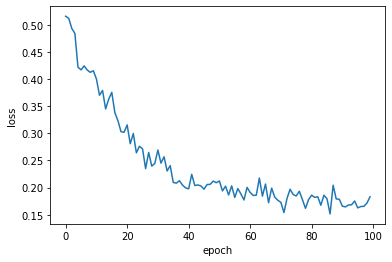

In [15]:
plt.plot(loss_)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'dice coefficient')

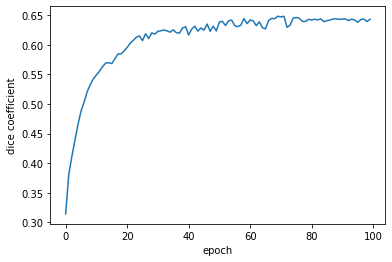

In [16]:
plt.plot(acc_)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')

In [17]:
model_path = '/home/zhangj41/HW/group_proj/Immune_nuclei_models/unet_epoch90.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

34
torch.Size([100, 3, 64, 64]) torch.Size([100, 1, 64, 64]) torch.Size([100, 1, 64, 64])


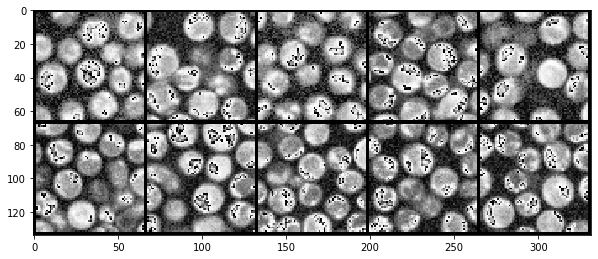

In [18]:
batch_datas, batch_labels = next(iter(DATALOADER_TEST)) 
batch_labels.unsqueeze_(1)

print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
img = make_grid(batch_datas[0:10], nrow=5, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()

pred_masks = model(batch_datas)
print(batch_datas.size(), batch_labels.size(), pred_masks.size())

torch.Size([3, 64, 64])


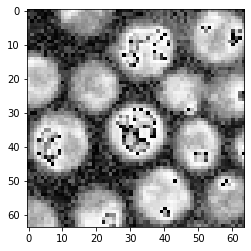

In [19]:
batch_data = batch_datas[0]
print(batch_data.size())
batch_data = batch_data.cpu().data.numpy()
plt.imshow(np.transpose(batch_data, (1,2,0)), cmap='gray', vmin=0, vmax=1)

torch.Size([64, 64])


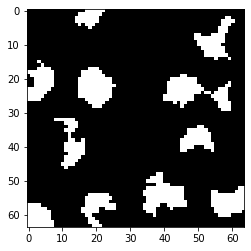

In [20]:
batch_label = batch_labels[0]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

torch.Size([64, 64])


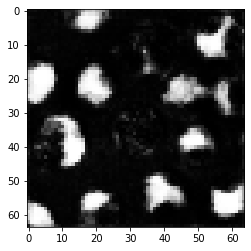

In [21]:
pred_mask = pred_masks[0]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

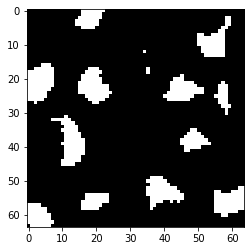

In [22]:
pred_mask[pred_mask>0.5] = 1
pred_mask[pred_mask<=0.5] = 0
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

## Metrics

In [14]:
model_path = '/home/zhangj41/HW/group_proj/Immune_nuclei_models/unet_epoch90.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

solver = CellSeg(unet=model)
iou_avg, precision_avg, dice_coeff_avg = solver.eval_epoch(dataloader=DATALOADER_TEST)

Normal IOU of the dataset: 0.643747
Normal PREC of the dataset: 0.789404
Normal DICE SCORE of the dataset: 0.997796


## Whole image mask

In [46]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
#     plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
    return img_eq

img_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [47]:
model_path = '/home/zhangj41/HW/group_proj/Immune_nuclei_models/unet_epoch90.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

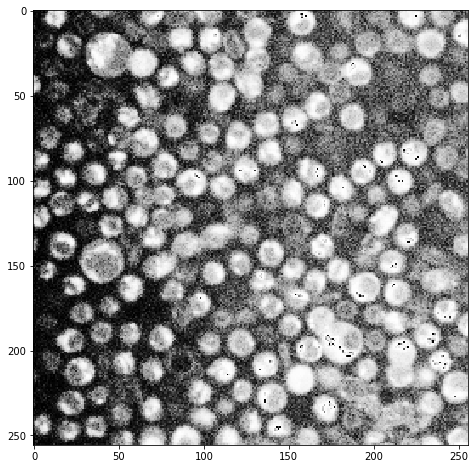

In [53]:
### read the whole image and convert to torch.Tensor
image_loc = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.tiff'
image_save = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Tcells_Th0_1n_photons.png'
cell_img = img_preprocess(img_dir=image_loc)
cell_img = Image.fromarray(cell_img)
cell_img.save(image_save)

imgs = Image.open(image_save).convert('RGB')
imgs = img_transform(imgs)

npimg = imgs.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([256, 256])


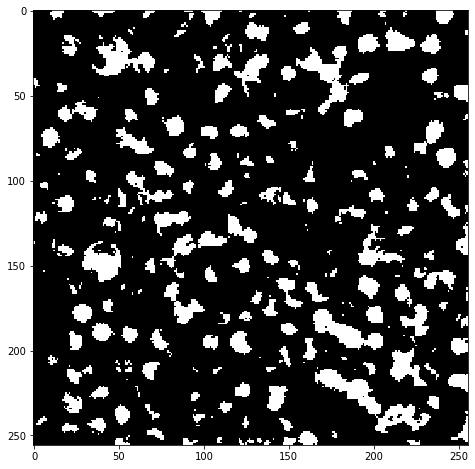

In [57]:
imgs.unsqueeze_(0)
imgs = imgs.cuda()
# imgs.size()

pred_mask = model(imgs)
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
pred_mask[pred_mask>=0.5] = 1
pred_mask[pred_mask<0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

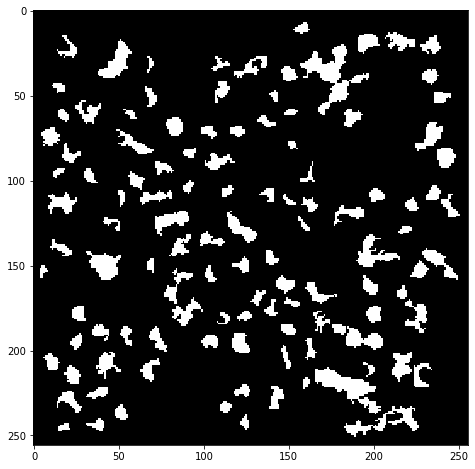

In [62]:
image_loc = '/home/zhangj41/HW/group_proj/Immune-Cells_2D/190718_Tcells/Th0/Masks/Tcells_Th0_1n_photons_nuclei.tiff'
image = imageio.imread(image_loc).astype("uint8")

image[image>0.5] = 1
image[image<=0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=1)